In [1]:
%load_ext autoreload
%autoreload
import tensorflow as tf
import numpy as np
import surreal_single, config
import functools, operator, copy
import tensorflow.contrib.slim as slim
from nets import resnet_v2
from nets.mobilenet import mobilenet_v2
from tensor_info2 import INPUT_TENSOR_INFO, OUTPUT_TENSOR_INFO
tf.reset_default_graph()

/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
types = tuple(t['type'] for t in INPUT_TENSOR_INFO)
config.BATCH_SIZE = 10
input_tensors = tf.data.Dataset.from_generator(surreal_single.load, types) \
                               .batch(config.BATCH_SIZE) \
                               .prefetch(config.PREFETCH_SIZE) \
                               .make_one_shot_iterator() \
                               .get_next()
tensors = {}
for tensor, info in zip(input_tensors, INPUT_TENSOR_INFO):
    tensor.set_shape(info['shape'])
    tensors[info['name']] = tensor
print(tensors)

{'image': <tf.Tensor 'IteratorGetNext:0' shape=(10, 401, 401, 3) dtype=float32>, 'hm': <tf.Tensor 'IteratorGetNext:1' shape=(10, 401, 401, 16) dtype=float32>, 'so_x': <tf.Tensor 'IteratorGetNext:2' shape=(10, 401, 401, 16) dtype=float32>, 'so_y': <tf.Tensor 'IteratorGetNext:3' shape=(10, 401, 401, 16) dtype=float32>, 'mo_x': <tf.Tensor 'IteratorGetNext:4' shape=(10, 401, 401, 30) dtype=float32>, 'mo_y': <tf.Tensor 'IteratorGetNext:5' shape=(10, 401, 401, 30) dtype=float32>}


In [3]:
config.STRIDE = 16

MD_H = int((config.TAR_H-1)//config.STRIDE)+1
MD_W = int((config.TAR_W-1)//config.STRIDE)+1

DEPTH = [ti['shape'][-1] for ti in OUTPUT_TENSOR_INFO]
RESULT_SHAPE = (config.BATCH_SIZE, MD_H, MD_W, sum(DEPTH))
RESULT_SIZE = functools.reduce(operator.mul, RESULT_SHAPE[1:])
OUTPUT_SHAPE = (config.BATCH_SIZE, config.TAR_H, config.TAR_W, sum(DEPTH))
OUTPUT_SIZE = functools.reduce(operator.mul, OUTPUT_SHAPE[1:])


In [4]:
def bilinear(indices):
    oy = tf.clip_by_value(indices[1], 0, MD_H-1)
    ox = tf.clip_by_value(indices[2], 0, MD_W-1)
    iy = [tf.floor(oy), tf.ceil(oy + 1e-9)]
    ix = [tf.floor(ox), tf.ceil(ox + 1e-9)]
    idx_p = []
    for y in iy:
        for x in ix:
            indices[1] = y
            indices[2] = x
            idx = tf.cast(tf.stack(indices, axis=-1), tf.int32)
            p = (1 - tf.abs(y - oy)) * (1 - tf.abs(x - ox))
            idx_p.append((idx, p))
    return idx_p

def gather_bilinear(params, indices):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.gather_nd(params, idx)
        res.append(r * p)
    return tf.add_n(res)

def scatter_bilinear(params, indices, shape):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.scatter_nd(idx, params, shape)
        if len(r.shape) > len(p.shape):
            p = tf.expand_dims(p, axis=-1)
        res.append(r * p)
    return tf.add_n(res)

In [5]:
def resize(tensor):
    return tf.image.resize_images(
        tensor,
        (config.TAR_H, config.TAR_W),
        method=tf.image.ResizeMethod.BILINEAR,
        align_corners=True)

with slim.arg_scope(resnet_v2.resnet_arg_scope()):
    _, end_points = resnet_v2.resnet_v2_101(tensors['image'], output_stride=config.STRIDE)
    model_output = end_points['resnet_v2_101/block4']
    print('model_output', model_output)
    hm_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=tf.sigmoid)
    so_x_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=None)
    so_y_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=None)
    mo_x_pred = slim.conv2d(model_output, config.NUM_EDGE, [1, 1], activation_fn=None)
    mo_y_pred = slim.conv2d(model_output, config.NUM_EDGE, [1, 1], activation_fn=None)

    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    b, y, x, i = np.mgrid[:config.BATCH_SIZE, :MD_H, :MD_W, :config.NUM_EDGE]
    for _ in range(config.NUM_RECURRENT):
        mo_p = [b, y+mo_y_pred, x+mo_x_pred, i]
        mo_x_pred = gather_bilinear(so_x_pred, mo_p) + mo_x_pred
        mo_y_pred = gather_bilinear(so_y_pred, mo_p) + mo_y_pred
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred = [resize(x) for x in [hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]]
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    so_x_pred, so_y_pred, mo_x_pred, mo_y_pred = [x * config.STRIDE for x in [so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]]
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
model_output Tensor("resnet_v2_101/block4/unit_3/bottleneck_v2/add:0", shape=(10, 26, 26, 2048), dtype=float32)
Tensor("Conv/Sigmoid:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_1/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_2/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_3/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 30), dtype=float32) Tensor("Conv_4/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 30), dtype=float32)
Tensor("Conv/Sigmoid:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_1/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_2/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("add_12:0", shape=(10, 26, 26, 30), dtype=float32) Tensor("add_15:0", shape=(10, 26, 26, 30), dtype=float32)
Tensor("resize_images/ResizeBilinear:0", shape=(10, 401, 401, 16), dtype=

In [6]:
hm_loss = - tf.reduce_mean(tensors['hm'] * tf.log(hm_pred + 1e-9) + (1 - tensors['hm']) * tf.log(1 - hm_pred + 1e-9))
so_loss = tf.abs(tensors['so_x'] - so_x_pred) / config.RADIUS + tf.abs(tensors['so_y'] - so_y_pred) / config.RADIUS
mo_loss = tf.abs(tensors['mo_x'] - mo_x_pred) / config.RADIUS + tf.abs(tensors['mo_y'] - mo_y_pred) / config.RADIUS

disc_only = tf.cast(tensors['hm'], tf.float32)
disc_size = tf.reduce_sum(disc_only, axis=[1, 2]) + 1e-9
so_loss = tf.reduce_mean(tf.reduce_sum(so_loss * disc_only, axis=[1, 2]) / disc_size)

disc_only = tf.cast(tf.gather(tensors['hm'], config.EDGES[:, 0], axis=-1), tf.float32)
disc_size = tf.reduce_sum(disc_only, axis=[1, 2]) + 1e-9
mo_loss = tf.reduce_mean(tf.reduce_sum(mo_loss * disc_only, axis=[1, 2]) / disc_size)

In [15]:
total_loss = hm_loss * 4.0 + so_loss * 1.0 + mo_loss * 0.5

In [16]:
tf.summary.scalar('losses/hm_loss', hm_loss)
tf.summary.scalar('losses/so_loss', so_loss)
tf.summary.scalar('losses/mo_loss', mo_loss)
tf.summary.scalar('losses/total_loss', total_loss)

<tf.Tensor 'losses/total_loss:0' shape=() dtype=string>

In [17]:
tf.summary.histogram("pred_dist/resnet", model_output)
tf.summary.histogram("pred_dist/heatmap", hm_pred)
tf.summary.histogram("pred_dist/short_off_x", so_x_pred)
tf.summary.histogram("pred_dist/short_off_y", so_y_pred)
tf.summary.histogram("pred_dist/mid_off_x", mo_x_pred)
tf.summary.histogram("pred_dist/mid_off_y", mo_y_pred)

tf.summary.histogram("true_dist/heatmap", tensors['hm'])
tf.summary.histogram("true_dist/short_off_x", tensors['so_x'])
tf.summary.histogram("true_dist/short_off_y", tensors['so_y'])
tf.summary.histogram("true_dist/mid_off_x", tensors['mo_x'])
tf.summary.histogram("true_dist/mid_off_y", tensors['mo_y'])

optimizer = tf.train.AdamOptimizer()
train_op = slim.learning.create_train_op(total_loss, optimizer)

checkpoint_path = 'resnet/resnet_v2_101.ckpt'
variables = slim.get_model_variables()
restore_map = {}
for v in variables:
    if not v.name.startswith('resnet'):
        continue
    org_name = v.name.split(':')[0]
    restore_map[org_name] = v
    print(org_name, ':', v.name)
init_assign_op, init_feed_dict = slim.assign_from_checkpoint(checkpoint_path, restore_map)

resnet_v2_101/conv1/weights : resnet_v2_101/conv1/weights:0
resnet_v2_101/conv1/biases : resnet_v2_101/conv1/biases:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/gamma : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/gamma:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/beta : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/beta:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_mean : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_mean:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_variance : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_variance:0
resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/weights : resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/weights:0
resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/biases : resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/biases:0
resnet_v2_101/block1/unit_1/bottleneck_v2/conv1/weights : resnet_v2_101/block1/unit_1/bottleneck_v2/conv1/weights:0
resnet_v2_101/block1/unit_1/bottleneck

In [18]:
import time, os, shutil
#log_dir = 'logs/log_' + str(time.time())[-5:]
log_dir = 'logs/res_log_test'
shutil.rmtree(log_dir)
os.mkdir(log_dir)

In [ ]:
def InitAssignFn(sess):
    sess.run(init_assign_op, init_feed_dict)
tf.contrib.slim.learning.train(train_op,
                               '/home/ubuntu/personlab/'+log_dir,
                               init_fn=InitAssignFn,
                               log_every_n_steps=100,
                               save_summaries_secs=30,
                              )

In [ ]:
from tensorflow.python.tools import inspect_checkpoint
inspect_checkpoint.print_tensors_in_checkpoint_file(checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=True)

In [11]:

saver = tf.train.Saver()
checkpoint_path = '/Users/minsubsim/work/personlab2/logs/res_log_test/model.ckpt-44109'

INFO:tensorflow:Restoring parameters from /Users/minsubsim/work/personlab2/logs/res_log_test/model.ckpt-44109


RuntimeError: Attempted to use a closed Session.

In [12]:

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    m_out, img, hm, so_x, so_y, mo_x, mo_y = sess.run([model_output, tensors['image'], hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred])


INFO:tensorflow:Restoring parameters from /Users/minsubsim/work/personlab2/logs/res_log_test/model.ckpt-44109


InvalidArgumentError: flat indices[50699, :] = [2, 14, 24, 29] does not index into param (shape: [10,26,26,16]).
	 [[Node: GatherNd_7 = GatherNd[Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Conv_2/BatchNorm/FusedBatchNorm, Cast_7)]]

Caused by op 'GatherNd_7', defined at:
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-ea5a7336d28e>", line 23, in <module>
    mo_y_pred = gather_bilinear(so_y_pred, mo_p) + mo_y_pred
  File "<ipython-input-4-d6679ea75887>", line 20, in gather_bilinear
    r = tf.gather_nd(params, idx)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2975, in gather_nd
    "GatherNd", params=params, indices=indices, name=name)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): flat indices[50699, :] = [2, 14, 24, 29] does not index into param (shape: [10,26,26,16]).
	 [[Node: GatherNd_7 = GatherNd[Tindices=DT_INT32, Tparams=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Conv_2/BatchNorm/FusedBatchNorm, Cast_7)]]


In [ ]:
import cv2
from matplotlib import pyplot as plt
from matplotlib import rcParams

def overlay(img, over, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    out *= 1-alpha
    if len(over.shape)==2:
        out += alpha*over[:,:,np.newaxis]
    else:
        out += alpha*over    
    return out
b_i = 9
plt.figure()
plt.imshow(overlay(img[b_i, ...], np.max(hm[b_i, ...], axis=-1), alpha=0.7))

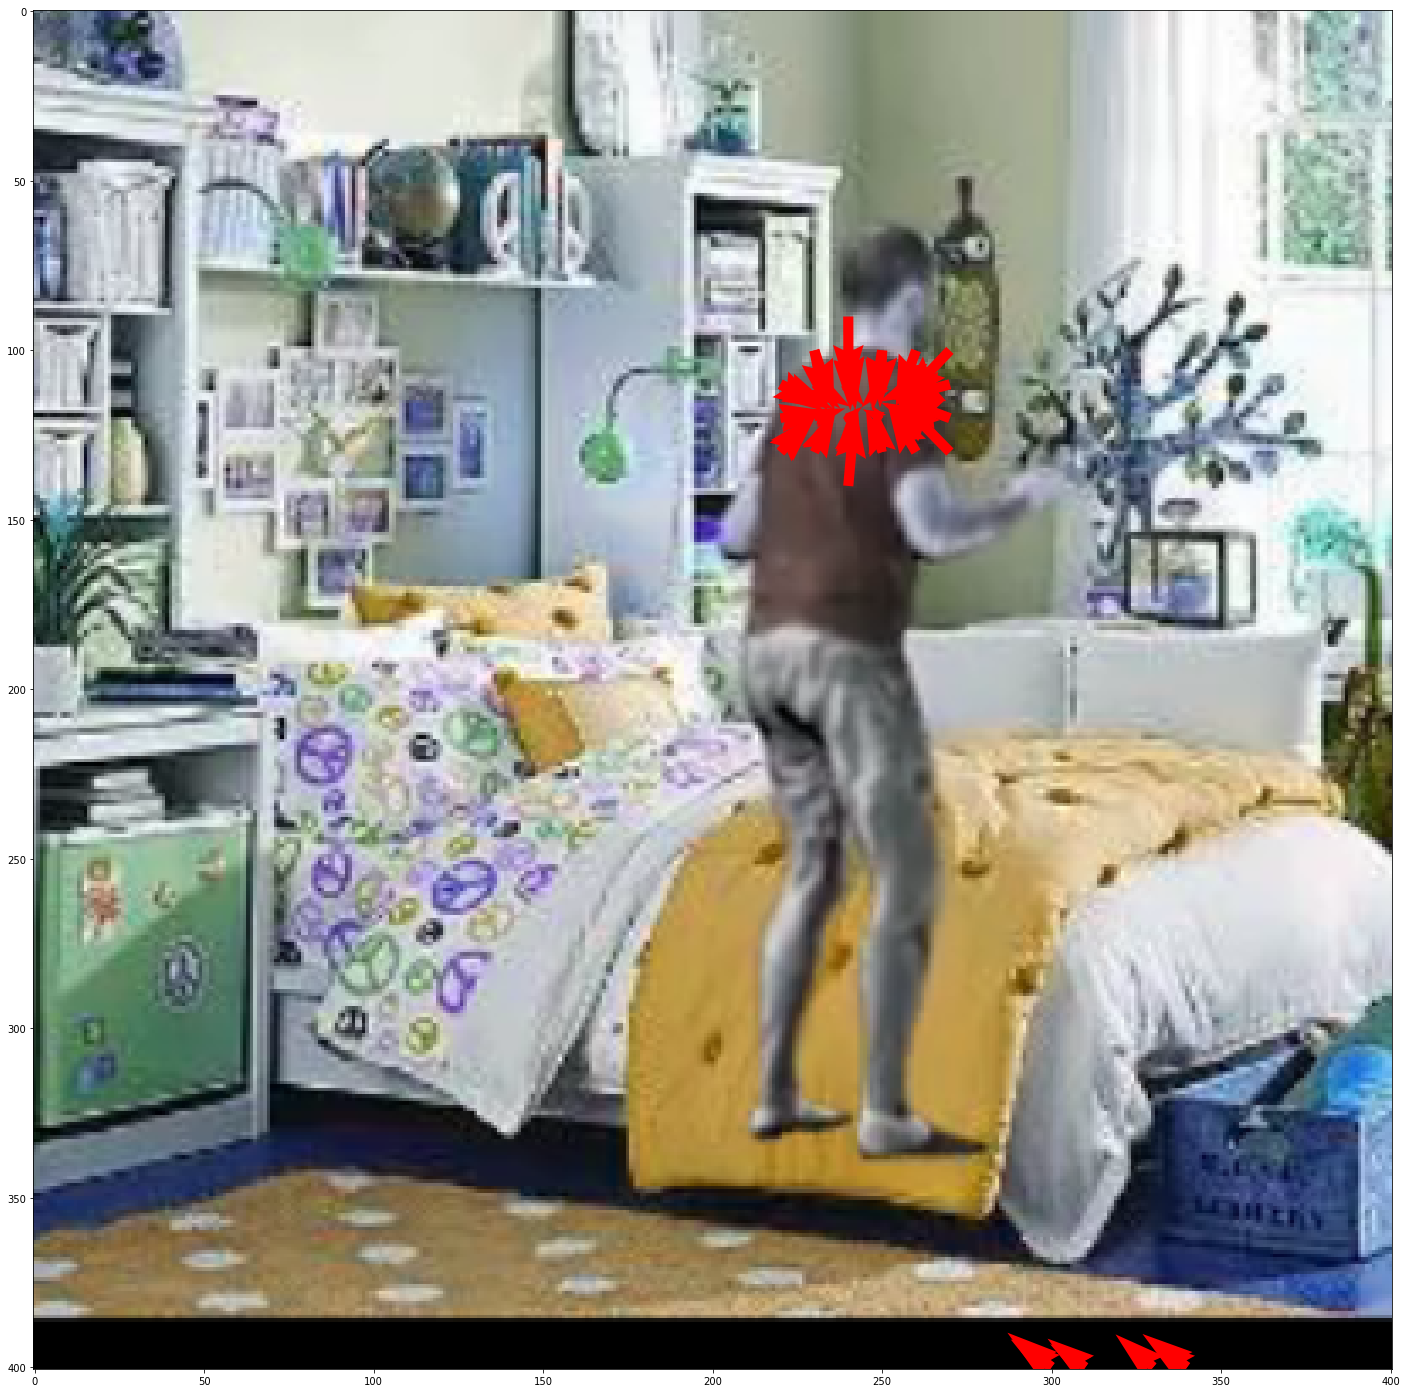

In [64]:
plt.figure()
rcParams['figure.figsize'] = [25, 25]
res = []

def pp(img, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    return out

SURREAL_KP_MAP = [
    15, #턱 0
    12, #목 1
    9,  #가슴 2
    16, 18, 20, #왼쪽 어깨, 팔꿈치, 손목 3 4 5
    17, 19, 21, #오른쪽 어깨, 팔꿈치, 손목 6 7 8
    3, #배 9
    1, 4, 7, #왼쪽 엉덩이, 무릎, 발목 10 11 12
    2, 5, 8, #왼쪽 엉덩이, 무릎, 발목 13 14 15
]
for x in range(config.TAR_H):
    if x%10 != 0:
        continue
    for y in range(config.TAR_W):
        if y%10 != 0:
            continue
        i = 12
        for i in [3, 6]:
            if hm[b_i][x][y][i]>0.5 and abs(so_x[b_i][x][y][i]) + abs(so_y[b_i][x][y][i]) > 0:
                res.append((x, y, so_x[b_i][x][y][i], so_y[b_i][x][y][i]))
X, Y, U, V = zip(*res)
plt.quiver(Y, X, U, V, color='r', angles='xy', scale_units='xy', scale=1)
plt.imshow(pp(img[b_i],alpha=0.5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


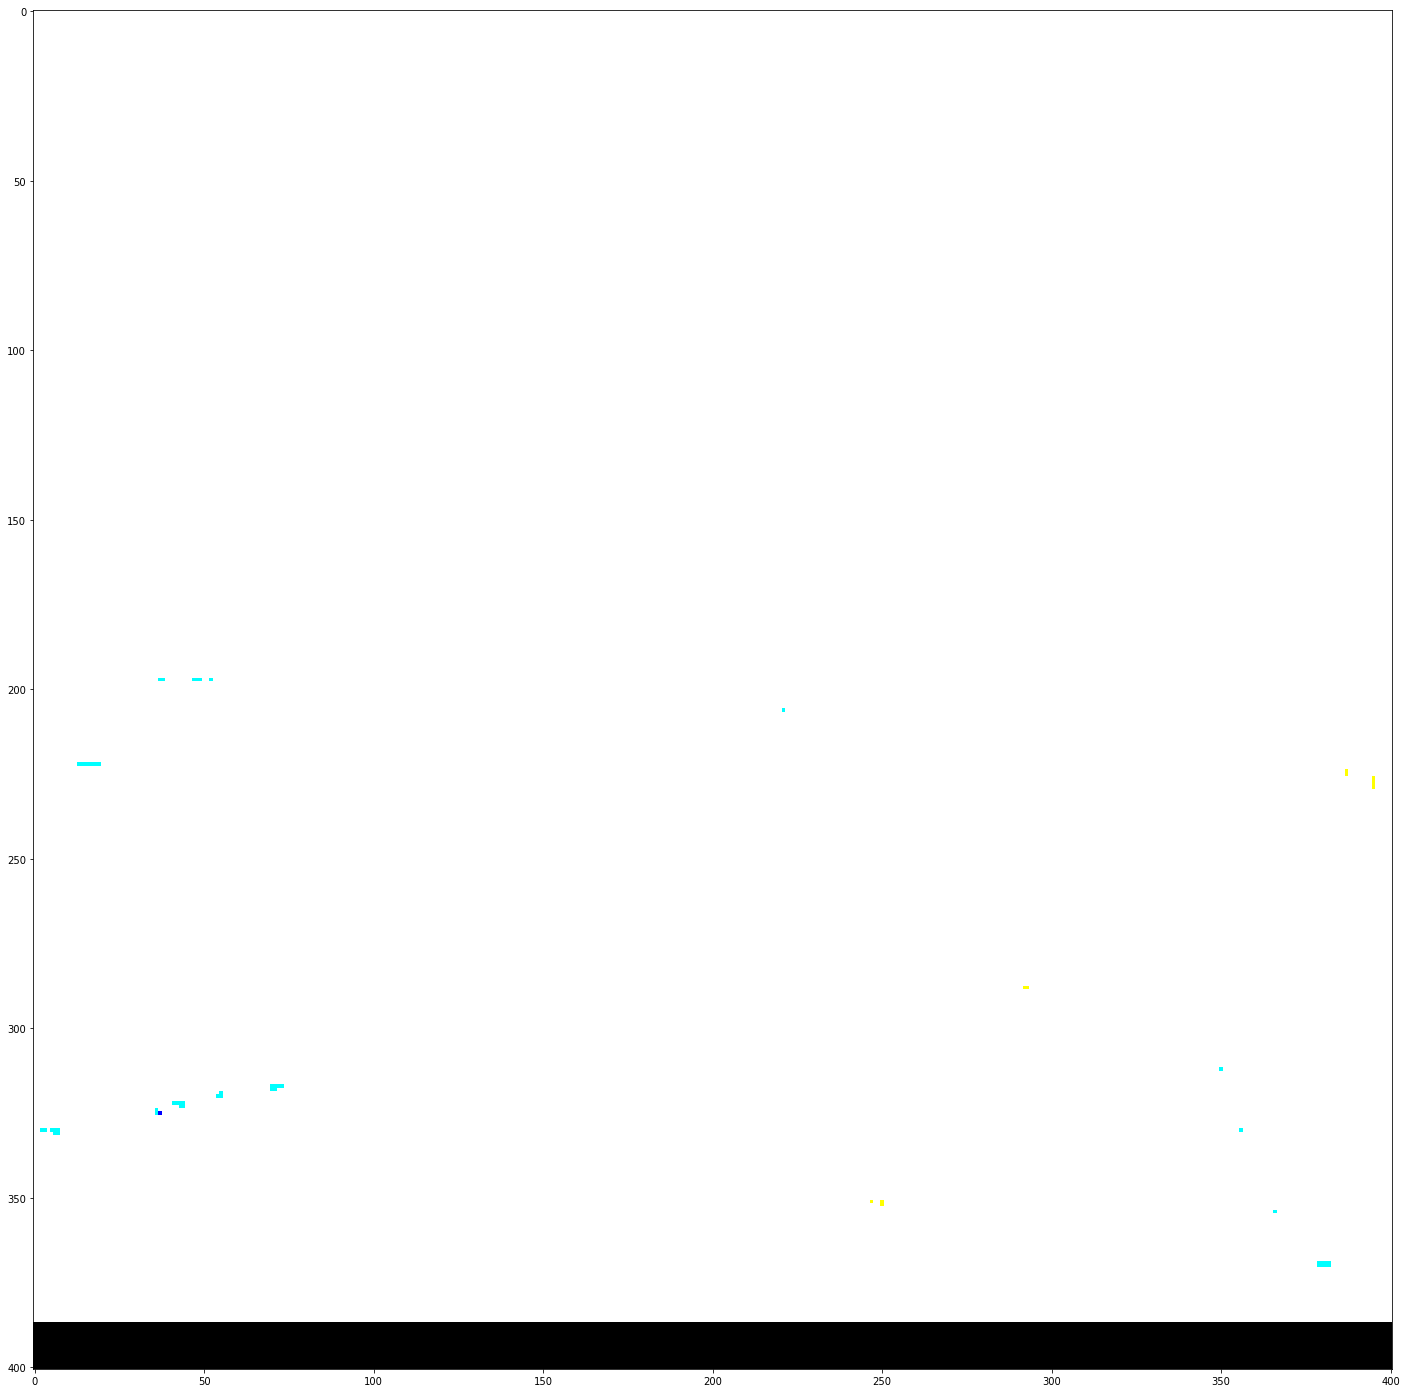

In [65]:

plt.imshow(img[b_i, ...])

In [ ]:
config.EDGES[:, ::-1]